In [1]:

!pip install pygame
!pip install torch


pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0: Total Reward = -94.51, Epsilon = 0.997


/var/folders/hd/nth13llx7673wbk87t31zck00000gn/T/ipykernel_90340/1626295881.py:129: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


Episode 10: Total Reward = -71.91, Epsilon = 0.967
Episode 20: Total Reward = -88.35, Epsilon = 0.939
Episode 30: Total Reward = -72.58, Epsilon = 0.911
Episode 40: Total Reward = -60.78, Epsilon = 0.884
Episode 50: Total Reward = -66.23, Epsilon = 0.858
Episode 60: Total Reward = -69.27, Epsilon = 0.833
Episode 70: Total Reward = -71.01, Epsilon = 0.808
Episode 80: Total Reward = -68.88, Epsilon = 0.784
Episode 90: Total Reward = -90.82, Epsilon = 0.761
Episode 100: Total Reward = -63.06, Epsilon = 0.738
Episode 110: Total Reward = -77.42, Epsilon = 0.716
Episode 120: Total Reward = -68.05, Epsilon = 0.695
Episode 130: Total Reward = -64.44, Epsilon = 0.675
Episode 140: Total Reward = -78.76, Epsilon = 0.655
Episode 150: Total Reward = -63.08, Epsilon = 0.635
Episode 160: Total Reward = -67.53, Epsilon = 0.616
Episode 170: Total Reward = -99.26, Epsilon = 0.598
Episode 180: Total Reward = -69.80, Epsilon = 0.581
Episode 190: Total Reward = -72.55, Epsilon = 0.563
Episode 200: Total Re

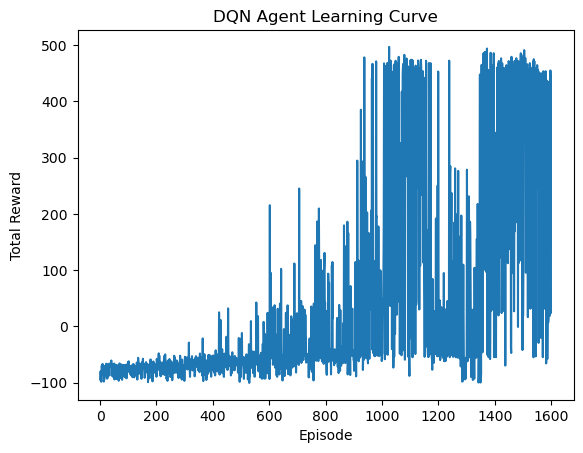

In [ ]:
import pygame
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# === Game Settings ===
WIDTH, HEIGHT = 288, 512
PIPE_GAP = 100
BIRD_X = 50
FPS = 30

# === DQN Settings ===
GAMMA = 0.99
LR = 1e-3
MEMORY_SIZE = 5000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.997
TARGET_UPDATE = 50

# === Initialize Pygame ===
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
clock = pygame.time.Clock()

# === Game Environment ===
class FlappyBirdEnv:
    def __init__(self, screen, clock):
        self.screen = screen
        self.clock = clock
        self.frame_count = 0
        self.reset()

    def reset(self):
        self.bird_y = HEIGHT // 2
        self.bird_vel = 0
        self.pipe_x = WIDTH
        self.pipe_top = random.randint(50, HEIGHT - PIPE_GAP - 50)
        self.done = False
        self.score = 0
        self.frame_count = 0
        return self._get_state()

    def _get_state(self):
        bird_mid = self.bird_y + 15
        pipe_center = self.pipe_top + PIPE_GAP / 2
        return np.array([
            bird_mid / HEIGHT,
            self.bird_vel / 10.0,
            (self.pipe_x - BIRD_X) / WIDTH,
            (pipe_center - bird_mid) / HEIGHT
        ], dtype=np.float32)

    def step(self, action):
        self.bird_vel += 1
        if action == 1:
            self.bird_vel = -8
        self.bird_y += self.bird_vel
        self.pipe_x -= 4
        self.frame_count += 1

        pipe_center = self.pipe_top + PIPE_GAP / 2
        distance_from_center = abs((self.bird_y + 15) - pipe_center)
        reward = 0.1 + (1.0 - (distance_from_center / (HEIGHT / 2)))

        if self.pipe_x < -50:
            self.pipe_x = WIDTH
            self.pipe_top = random.randint(50, HEIGHT - PIPE_GAP - 50)
            self.score += 1
            reward += 1

        if (self.bird_y > HEIGHT or self.bird_y < 0 or
           (self.pipe_x < BIRD_X + 30 < self.pipe_x + 50 and
            (self.bird_y < self.pipe_top or self.bird_y > self.pipe_top + PIPE_GAP))):
            reward = -100
            self.done = True

        if self.frame_count > 500:
            self.done = True

        return self._get_state(), reward, self.done

    def render(self):
        self.screen.fill((135, 206, 250))
        pygame.draw.rect(self.screen, (255, 255, 0), (BIRD_X, self.bird_y, 30, 30))
        pygame.draw.rect(self.screen, (0, 255, 0), (self.pipe_x, 0, 50, self.pipe_top))
        pygame.draw.rect(self.screen, (0, 255, 0), (self.pipe_x, self.pipe_top + PIPE_GAP, 50, HEIGHT))

        # Debug: draw center lines
        pygame.draw.line(self.screen, (255, 0, 0), (0, self.bird_y + 15), (WIDTH, self.bird_y + 15), 1)
        pipe_center = self.pipe_top + PIPE_GAP // 2
        pygame.draw.line(self.screen, (0, 0, 255), (0, pipe_center), (WIDTH, pipe_center), 1)

        pygame.display.flip()
        self.clock.tick(FPS)

# === DQN Model ===
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# === Helper Functions ===
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1)
    else:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state)).argmax().item()

def train_step(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    batch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.BoolTensor(dones).unsqueeze(1)

    q_values = policy_net(states).gather(1, actions)
    with torch.no_grad():
        q_next = target_net(next_states).max(1, keepdim=True)[0]
        q_target = rewards + GAMMA * q_next * (~dones)

    loss = nn.MSELoss()(q_values, q_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# === Main Training Loop ===
NUM_EPISODES = 1600
env = FlappyBirdEnv(screen, clock)
policy_net = DQN(4, 2)
target_net = DQN(4, 2)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = deque(maxlen=MEMORY_SIZE)

epsilon = EPSILON_START
rewards_list = []

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done = env.step(action)
        memory.append((state, action, reward, next_state, done))
        train_step(policy_net, target_net, memory, optimizer)
        state = next_state
        total_reward += reward

        if episode % 200 == 0:
            env.render()

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
    rewards_list.append(total_reward)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 10 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

# === Visualization ===
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Learning Curve')
plt.show()

# === Agent Playback ===
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
clock = pygame.time.Clock()
env = FlappyBirdEnv(screen, clock)

state = env.reset()
done = False
running = True

while not done and running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            done = True

    env.render()
    action = select_action(state, policy_net, epsilon=0.0)
    next_state, _, done = env.step(action)
    state = next_state
    pygame.time.wait(10)

pygame.quit()
